**Sentiments in graphs**

Simple visualisations of the data obtained are shown below.

**Setup**

In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib

**Chart visualisation**

In [3]:
import pandas as pd

versos_al_paso_sentiment_file_path = './output/versosalpaso_sentiment_text-davinci-003.csv'
versos_al_paso_sentiment = pd.read_csv(versos_al_paso_sentiment_file_path, sep=";", encoding='utf-8')
versos_al_paso_sentiment.columns

Index(['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso',
       'direccion', 'sentiment'],
      dtype='object')

Check that all sentences have a sentiment associated with it 

In [4]:
import unittest

versos_nan = versos_al_paso_sentiment[versos_al_paso_sentiment.sentiment.isna()].verso.tolist()

tc = unittest.TestCase()
tc.assertListEqual([], versos_nan)

**A pie chart for sentiment values**

In [5]:
df = versos_al_paso_sentiment.groupby(['sentiment'])['sentiment'].count()
df

sentiment
negative      18
neutral       56
positive    1026
Name: sentiment, dtype: int64

List of negative sentences

In [6]:
versos_al_paso_sentiment[versos_al_paso_sentiment['sentiment'].eq('negative')].verso.tolist()

['La política tiene colgado el cartel de rebajas',
 'Peladitos ven TV y quieren ser así, están aprendiendo a matar antes que a vivir',
 'Nadie es un candidato tan popular para el agravio como una víctima',
 'La tristeza es vulgar si no es inmensa y esconde muchas veces un placer venenoso',
 'No hay nada más bello que lo que nunca he tenido, nada más amado que lo que perdí.',
 'Quizás lo que nos salva son los raros momentos en que no pasa nada.',
 'Madrid me duele.',
 'La cobardía se mide en ojalases..',
 '-\xa0El sermón del predicador es la oración del necio',
 'Lanzaré a tu noche oscura los dados de mis dudas',
 '¿Quién puede amar con la garganta rota?',
 'En vez de pájaro en mano prefiero una gran desbandada en la cabeza',
 'Te pido perdón por el daño que me hiciste.',
 'Algo está roto si el odio une tanto.',
 'Si el monstruo te da miedo ¿Por Qué le das de comer?',
 'Cuídate del recuerdo.',
 'O me paras los pies o esto se me va de las manos.',
 'Pecas. En todas sus acepciones.']

<Axes: title={'center': 'Sentiments'}>

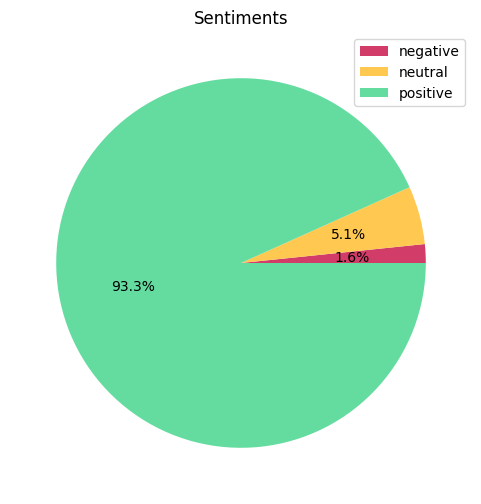

In [7]:
colors = ['#D23C69','#FFC850','#64DCA0']
df.plot.pie(legend=True, title='Sentiments', autopct='%1.1f%%', colors=colors, ylabel='', labeldistance=None, figsize=(6, 6))

**A chart by neighborhood**

In [8]:
no_of_neighborhoods = len(versos_al_paso_sentiment.barrio.unique())
print(f'There are {no_of_neighborhoods} neighborhoods')

There are 204 neighborhoods


It seems that a bar chart by district would be more interesting.

**A horizontal bar chart by district**

The district data will be added using [Nominatim](https://nominatim.org/)'s free [reverse geocoding API](https://nominatim.org/release-docs/latest/api/Reverse/). This API generates an address from a latitude and longitude with the following data depending on the zoom value (default 18) in the request

| zoom | address detail          |
| ----:| ----------------------- |
|    3 | country                 |
|    5 | state                   |
|    8 | county                  |
|   10 | city                    |
|   14 | suburb                  |
|   16 | major streets           |
|   17 | major and minor streets |
|   18 | building                |

For example, for the point

In [9]:
versos_al_paso_sentiment.iloc[0]

Unnamed: 0                                                    0
id                                                         1000
latitud                                               40.425239
longitud                                              -3.691217
autor                                    ﻿Mario Vaillo de Mingo
barrio                                                  ﻿CENTRO
verso         Quizá el secreto de la vida tan solo consista ...
direccion                          ﻿Calle de Génova-Plaza Colón
sentiment                                              positive
Name: 0, dtype: object

the request and answer will be

```bash
$ curl https://nominatim.openstreetmap.org/reverse\?format\=jsonv2\&lat\=40.4252387\&lon\=-3.6912172 | jq
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   765    0   765    0     0   1747      0 --:--:-- --:--:-- --:--:--  1746
{
  "place_id": 13807006,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright",
  "osm_type": "node",
  "osm_id": 1439704870,
  "lat": "40.4251606",
  "lon": "-3.6912452",
  "place_rank": 30,
  "category": "highway",
  "type": "bus_stop",
  "importance": 9.99999999995449e-06,
  "addresstype": "highway",
  "name": "Metro Colón",
  "display_name": "Metro Colón, Calle de Génova, Justicia, Chamberí, Centro, Madrid, Comunidad de Madrid, 28004, España",
  "address": {
    "highway": "Metro Colón",
    "road": "Calle de Génova",
    "quarter": "Justicia",
    "suburb": "Chamberí",
    "city_district": "Centro",
    "city": "Madrid",
    "state": "Comunidad de Madrid",
    "ISO3166-2-lvl4": "ES-MD",
    "postcode": "28004",
    "country": "España",
    "country_code": "es"
  },
  "boundingbox": [
    "40.4251106",
    "40.4252106",
    "-3.6912952",
    "-3.6911952"
  ]
}
```

Save a copy of sentiments with the new columns

In [14]:
versos_al_paso_geo = versos_al_paso_sentiment.copy()
versos_al_paso_geo['quarter'] = ''
versos_al_paso_geo['district'] = ''
versos_al_paso_geo['city'] = ''

versos_al_paso_geo_file_path = './output/versosalpaso_sentiment_text-davinci-003_geo.csv'
versos_al_paso_geo.to_csv(versos_al_paso_geo_file_path, sep=';', encoding='utf-8')
versos_al_paso_geo.columns

Index(['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso',
       'direccion', 'sentiment', 'quarter', 'district', 'city'],
      dtype='object')

Let's collect the data

In [15]:
import requests
from requests.exceptions import ConnectTimeout
import unittest

for i in versos_al_paso_geo.index:
    try:
        print(i, end='\r')

        #if 0 < len(versos_al_paso_geo.at[i, 'district']): # for a re-excution case
        #    continue

        url = f'https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat={versos_al_paso_geo.latitud[i]}&lon={versos_al_paso_geo.longitud[i]}'
        res = requests.get(url, timeout=(0.1,1))

        if res.ok:
            json = res.json()
            splitted_address = json['address']

            if 'city' in splitted_address:
                versos_al_paso_geo.at[i, 'city'] = splitted_address['city']
            if 'quarter' in splitted_address:
                versos_al_paso_geo.at[i, 'quarter'] = splitted_address['quarter']
            if 'city_district' in splitted_address:
                versos_al_paso_geo.at[i, 'district'] = splitted_address['city_district']
            else:
                versos_al_paso_geo.at[i, 'district'] = splitted_address['suburb']

    except ConnectTimeout:
        print(f'#{i} Request "{url}" has timed out\n')
    
    except Exception as e:
        print(f'#{i} An exception occurred: {str(e)}\n')

tc = unittest.TestCase()
empty_rows = len(versos_al_paso_geo[versos_al_paso_geo.district.eq('')].district.tolist())
tc.assertEqual(0, empty_rows)

Save full information

In [16]:
versos_al_paso_geo.to_csv(versos_al_paso_geo_file_path, sep=';', encoding='utf-8')

Changing district value 'Villaverde Alto, Casco Histórico de Villaverde' to 'Villaverde' was necessary

In [17]:
versos_al_paso_geo = pd.read_csv(versos_al_paso_geo_file_path, sep=';', encoding='utf-8')
versos_al_paso_geo.district.unique()

array(['Centro', 'Moratalaz', 'Latina', 'Villaverde', 'Salamanca',
       'Ciudad Lineal', 'Tetuán', 'Hortaleza', 'Retiro',
       'Fuencarral-El Pardo', 'Chamartín', 'Moncloa-Aravaca', 'Chamberí',
       'San Blas - Canillejas', 'Arganzuela', 'Carabanchel',
       'Puente de Vallecas', 'Usera', 'Villa de Vallecas', 'Vicálvaro',
       'Barajas'], dtype=object)

In [18]:
no_of_districts = len(versos_al_paso_geo.district.unique())
print(f'There are {no_of_districts} districts')

There are 21 districts


In [19]:
versos_al_paso_geo.groupby(['district'])['district'].count()

district
Arganzuela               53
Barajas                  11
Carabanchel              81
Centro                   70
Chamartín                75
Chamberí                 64
Ciudad Lineal            78
Fuencarral-El Pardo      65
Hortaleza                56
Latina                   75
Moncloa-Aravaca          63
Moratalaz                31
Puente de Vallecas       58
Retiro                   47
Salamanca                63
San Blas - Canillejas    53
Tetuán                   43
Usera                    46
Vicálvaro                23
Villa de Vallecas        12
Villaverde               33
Name: district, dtype: int64

In [21]:
table_by_barrio = pd.pivot_table(versos_al_paso_geo[['district', 'sentiment']], index='district', columns='sentiment', aggfunc=len, fill_value=0)
table_by_barrio

sentiment,negative,neutral,positive
district,,,
Arganzuela,1,4,48
Barajas,0,0,11
Carabanchel,2,7,72
Centro,1,2,67
Chamartín,0,4,71
Chamberí,1,0,63
Ciudad Lineal,0,1,77
Fuencarral-El Pardo,2,4,59
Hortaleza,0,5,51


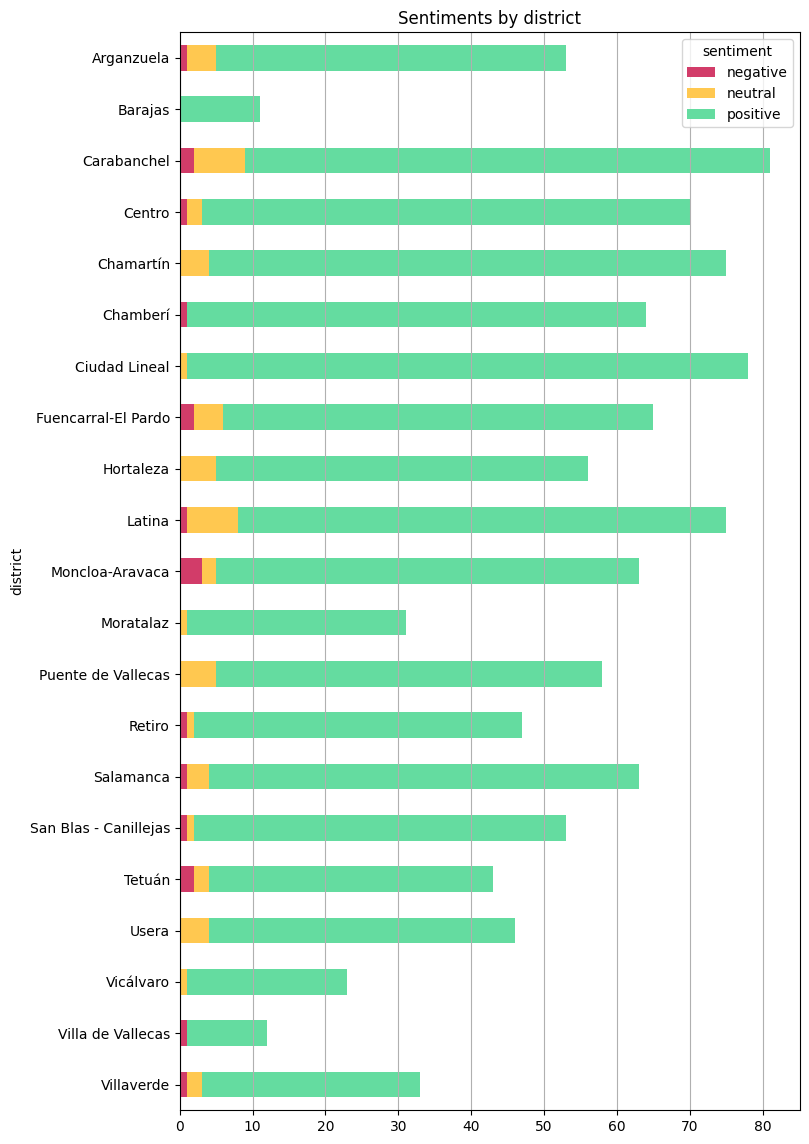

In [22]:
import matplotlib.pyplot as plt

colors = {'negative': '#D23C69', 'neutral': '#FFC850', 'positive': '#64DCA0'}
ax = table_by_barrio.plot.barh(color=colors, title='Sentiments by district', figsize=(8, 14), grid=True, stacked=True)
ax.invert_yaxis()
ax.grid(axis='y')